<a href="https://colab.research.google.com/github/kim1987/aiffel/blob/main/aiffel/exploration/new_exlporation_seventeen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

exploration_17
with hugging face  
with https://github.com/SKTBrain/KoBERT/tree/master/kobert_hf

In [ ]:
import torch
import torch.nn as nn
import torchtext

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
import requests
from datetime import datetime

In [ ]:
#!pip3 install gitpython

In [ ]:
#import time
#import git
#from git import RemoteProgress

In [ ]:
#import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
#import seaborn as sns
#from wordcloud import WordCloud

In [ ]:
if torch.cuda.is_available():
  print(torch.cuda.get_device_name())

A100-SXM4-40GB


데이터 로딩

In [ ]:
'''
os.mkdir('/content/data')
class CloneProgress(RemoteProgress):
  def update(self, op_code, cur_count, max_count=None, message=''):
      if message:
          print(message)

#print('Cloning into %s' % git_root)
git.Repo.clone_from(f'https://github.com/korquad/korquad.github.io', '/content/data', 
        branch='master', progress=CloneProgress())
'''

"\nos.mkdir('/content/data')\nclass CloneProgress(RemoteProgress):\n  def update(self, op_code, cur_count, max_count=None, message=''):\n      if message:\n          print(message)\n\n#print('Cloning into %s' % git_root)\ngit.Repo.clone_from(f'https://github.com/korquad/korquad.github.io', '/content/data', \n        branch='master', progress=CloneProgress())\n"

In [ ]:
'''
class MyDataSet(torch.utils.data.Dataset):

  def __init__(self,root_path, train=True):
    super().__init__()
    self.path = root_path
    self.train = train
      #download
    self.download()
      #unzip
    self.unzip()

  def download(self):
    location = 'train' if self.train else 'dev'
    if not os.path.exists(os.path.join(self.path,location)):
      os.mkdir(os.path.join(self.path,location))
      for i in range(1,14):
        url = f"https://github.com/korquad/korquad.github.io/raw/master/dataset/KorQuAD_2.0/train/KorQuAD_2.0_train_{str(i).zfill(2)}.zip"

        response = requests.get(url, stream=True)
        total_size_in_bytes= int(response.headers.get('content-length', 0))
        chunk_size = 4*1024
        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True,desc = f'{i}\'th file')
        with open(os.path.join(self.path,location,f'train{str(i).zfill(2)}.zip'), 'wb') as file:
            for data in response.iter_content(chunk_size=chunk_size):
                progress_bar.update(len(data))
                file.write(data)
        progress_bar.close()

  def unzip(self):
    location = 'train' if self.train else 'dev'
    if not os.path.exists(os.path.join(self.path,location,'unzip')):
      os.mkdir(os.path.join(self.path,location,'unzip'))
      for i in range(1,14):
        torchtext.utils.extract_archive(os.path.join(self.path,location,f'train{str(i).zfill(2)}.zip'),os.path.join(self.path,location,'unzip'))
'''

'\nclass MyDataSet(torch.utils.data.Dataset):\n\n  def __init__(self,root_path, train=True):\n    super().__init__()\n    self.path = root_path\n    self.train = train\n      #download\n    self.download()\n      #unzip\n    self.unzip()\n\n  def download(self):\n    location = \'train\' if self.train else \'dev\'\n    if not os.path.exists(os.path.join(self.path,location)):\n      os.mkdir(os.path.join(self.path,location))\n      for i in range(1,14):\n        url = f"https://github.com/korquad/korquad.github.io/raw/master/dataset/KorQuAD_2.0/train/KorQuAD_2.0_train_{str(i).zfill(2)}.zip"\n\n        response = requests.get(url, stream=True)\n        total_size_in_bytes= int(response.headers.get(\'content-length\', 0))\n        chunk_size = 4*1024\n        progress_bar = tqdm(total=total_size_in_bytes, unit=\'iB\', unit_scale=True,desc = f\'{i}\'th file\')\n        with open(os.path.join(self.path,location,f\'train{str(i).zfill(2)}.zip\'), \'wb\') as file:\n            for data in resp

---------giveup-------- 기존에 있는 토크나이저 이용하는것으로 변경. - trained 된 버트가 학습한 정보를 가져와야함. 해당 토크나이저 내용이 생각보다 방대하여 포기.

json from aiffel


In [ ]:
!cp /content/drive/MyDrive/colabdata/aiffel/ex_seventeen/KorQuAD_v1.0_dev.json /content
!cp /content/drive/MyDrive/colabdata/aiffel/ex_seventeen/KorQuAD_v1.0_train.json /content

In [ ]:
data_dev = pd.read_json('/content/KorQuAD_v1.0_dev.json',lines=True)

In [ ]:
data_train = pd.read_json('/content/KorQuAD_v1.0_train.json',lines=True)

In [ ]:
data_dev = data_dev['data']
data_train = data_train['data']

In [ ]:
len(data_train[0])

1420

In [ ]:
def split_data(data):
  pd_train = []
  for text in tqdm(data[0]):
    for content in text['paragraphs']:
      context = content['context']
      for question in content['qas']:
        ans = question['answers'][0]['text']
        qas = question['question']
        pd_train.append({'qas':qas,'context': context,'ans':ans})
  return pd.DataFrame(pd_train)

In [ ]:
pd_train = split_data(data_train)

  0%|          | 0/1420 [00:00<?, ?it/s]

In [ ]:
pd_dev = split_data(data_dev)

  0%|          | 0/140 [00:00<?, ?it/s]

In [ ]:
!pip install transformers
!pip install SentencePiece
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

     |████████████████████████████████| 3.1 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 73.1 MB/s 
     |████████████████████████████████| 3.3 MB 67.4 MB/s 
     |████████████████████████████████| 895 kB 78.2 MB/s 
     |████████████████████████████████| 61 kB 645 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 4.9 MB/s 
  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-5u7ctbcd/kobert-tokenizer_4e1a5421a2f94a83b84ced3b9a94d1d9
  Running command git clone -q https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-5u7ctbcd/kobert-tokenizer_4e1a5421a2f94a83b84ced3b9a94d1d9
  Created wheel for kobert-tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4648 sha256=2b7cd24462a30cf0c839a0462ccaf8c39661186ae16c904368da221f52cf684f
  Stored in directory: /tmp/pip-ephem-wheel-cache-nm2dfes8/wheels/

In [ ]:
import transformers

In [ ]:
import kobert_tokenizer

In [ ]:
tokenizer = kobert_tokenizer.KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

Downloading:   0%|          | 0.00/363k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/244 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/432 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
max_len = 498
pd_train=pd_train[pd_train['context'].apply(len)+pd_train['qas'].apply(len)+1<=max_len].reset_index().drop('index',axis=1)
pd_dev=pd_dev[pd_dev['context'].apply(len)+pd_dev['qas'].apply(len)+1<=max_len].reset_index().drop('index',axis=1)

In [ ]:
tqdm.pandas()

In [ ]:
test = pd_train.progress_apply(lambda row: tokenizer.encode_plus(text = row['qas'],text_pair=row['context'],padding='max_length',max_length=max_len+2),axis=1)

  0%|          | 0/30436 [00:00<?, ?it/s]

In [ ]:
pd_train['context'] = pd_train.progress_apply(lambda row: tokenizer.encode_plus(text = row['qas'],text_pair=row['context'],padding='max_length',max_length=max_len+2),axis=1)
pd_train['ans'] = pd_train['ans'].progress_apply(lambda x : tokenizer.encode_plus(x)['input_ids'])
pd_dev['context'] = pd_dev.progress_apply(lambda row: tokenizer.encode_plus(text = row['qas'],text_pair=row['context'],padding='max_length',max_length=max_len+2),axis=1)
pd_dev['ans'] = pd_dev['ans'].progress_apply(lambda x : tokenizer.encode_plus(x)['input_ids'])

  0%|          | 0/30436 [00:00<?, ?it/s]

  0%|          | 0/30436 [00:00<?, ?it/s]

  0%|          | 0/2989 [00:00<?, ?it/s]

  0%|          | 0/2989 [00:00<?, ?it/s]

In [ ]:
def find(data):
  data['ansloc']=[[max_len+1,max_len+1]]*len(data)
  for idx in tqdm(range(len(data))):
    len_ans = len(data['ans'][idx])-2
    ans = data['ans'][idx][1:-1]
    look_up = data['context'][idx]['input_ids']
    for i,loc in enumerate(look_up):
      if loc == ans[0] and ans == look_up[i:i+len_ans]:
        data['ansloc'][idx]=[i,i+len_ans]

In [ ]:
find(pd_train)
find(pd_dev)

  0%|          | 0/30436 [00:00<?, ?it/s]

  0%|          | 0/2989 [00:00<?, ?it/s]

In [ ]:
pd_train = pd_train[pd_train['ansloc'].apply(lambda x : x!=[499,499])].reset_index().drop('index',axis=1)
pd_dev = pd_dev[pd_dev['ansloc'].apply(lambda x : x!=[499,499])].reset_index().drop('index',axis=1)

In [ ]:
class MydataSet(torch.utils.data.Dataset):

  def __init__(self,data):
    super().__init__()
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    return (torch.tensor(self.data['context'][idx]['input_ids']),torch.tensor(self.data['context'][idx]['attention_mask']),torch.tensor(self.data['context'][idx]['token_type_ids'])),\
    (torch.cat([torch.tensor(self.data['ans'][idx]),torch.ones([500-len(self.data['ans'][idx])],dtype=torch.int32)]),torch.tensor(self.data['ansloc'][idx]))

In [ ]:
batch_size=16
set_train = MydataSet(pd_train)
set_dev = MydataSet(pd_dev)
load_train = torch.utils.data.DataLoader(set_train,batch_size=batch_size,shuffle=True)
load_dev = torch.utils.data.DataLoader(set_dev,batch_size=batch_size)

In [ ]:
test=next(iter(load_train))

In [ ]:
test[0][0][0]

tensor([   2, 1520, 4491, 6971, 7088, 3592, 7794, 4786, 7828, 4197, 7095, 3220,
        6107, 5760,  258,    3, 1864, 4786, 7828, 4197, 7095, 3220, 6107, 5760,
        1520, 4491, 6971, 7088, 3592, 7831,   54, 3437, 7909,  953, 5446, 6855,
        6107,   18, 6951, 6855,  249,  442,  389,  421,  427,  441,   46,  517,
         380,  429,  458,  517,  398,  412,  401, 6004, 5859, 2485, 6136,   40,
        5937, 2047,  993, 5944, 6855, 6797, 6217, 6896, 2856, 7788,   46, 2695,
        7483, 5932, 4427, 7483, 5931,   46, 4955, 4201, 7095,  518, 7020, 6705,
           8,  993, 5944, 6855, 6116, 4868, 5782,   54, 4397, 4297, 5757, 6037,
        6255, 4483, 6527, 6797, 6122,   46, 1311, 4297, 5757, 6037, 6255, 4483,
        6527, 6797, 6122,   46, 2298, 6527, 6797, 6122,   46, 3133, 6527, 6855,
          46, 3332, 6855, 6527, 6855, 5944, 7095, 3133, 6527, 6855, 5468, 7095,
        2048, 2658, 6855, 5933, 3437, 7909, 7100,   54, 1864, 5136, 5859, 6527,
        6855, 5468,   18, 6951, 6855,  2

In [ ]:
test[1][1]

tensor([[ 31,  37],
        [ 66,  67],
        [145, 150],
        [207, 210],
        [132, 138],
        [ 59,  63],
        [ 84,  87],
        [ 30,  34],
        [104, 109],
        [138, 145],
        [ 69,  72],
        [177, 179],
        [ 24,  26],
        [161, 165],
        [159, 167],
        [111, 117]])

모델

In [ ]:
#import gc
#gc.collect()

In [ ]:
#torch.cuda.ipc_collect()
#torch.cuda.empty_cache()

In [ ]:
#torch.cuda.memory_summary()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

In [ ]:
class BERT4KorQuAD(nn.Module):
    def __init__(self):
        super().__init__()

        self.bert = transformers.BertModel.from_pretrained('skt/kobert-base-v1')
        self.linear = nn.Linear(self.bert.config.hidden_size , 2)

    def forward(self, input_ids,attention_mask,token_type_ids):
        logits_lm = self.bert(input_ids,attention_mask,token_type_ids)

        hidden = self.linear(logits_lm[0]) # (bs, n_seq, 2)
        start_logits, end_logits = hidden.split(1,dim=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_outputs = start_logits.squeeze(-1).contiguous()

        end_outputs = end_logits.squeeze(-1).contiguous()

        return start_outputs, end_outputs

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

A100-SXM4-40GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
model = BERT4KorQuAD()
model.to(device)

BERT4KorQuAD(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [ ]:
epoch = 20

In [ ]:
loss_graph = []
accuracy_graph = []

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)

In [ ]:
for i in range(epoch):
  model.train()
  train_data = load_train
  for j,(src , tgt) in enumerate(tqdm(train_data)):

    optimizer.zero_grad()

    pred_start, pred_end = model(src[0].to(device),src[1].to(device),src[2].to(device))

    
    tgt = tgt[1].transpose(0,1)
    loss = (loss_fn(pred_start,tgt[0].to(device)) + loss_fn(pred_end,tgt[1].to(device)))/2

    loss.backward()

    optimizer.step()

    if j%100 == 0:
      match =(pred_start.argmax(1)==tgt[0].to(device)).sum()+(pred_end.argmax(1)==tgt[1].to(device)).sum()
      total = 2*tgt[0].size(0)
      print('\rloss: ',loss.item(),'   accuracy: ',match.item()/total,end="",flush=True)
      loss_graph.append(loss.item())
      accuracy_graph.append(match.item()/total)
  model.eval()
  dev_data = load_dev
  match =0
  total =0
  with torch.no_grad():
    for src , tgt in tqdm(dev_data):


      pred_start, pred_end = model(src[0].to(device),src[1].to(device),src[2].to(device))

      tgt = tgt[1].transpose(0,1)
      match += torch.sum(pred_start.argmax(1)==tgt[0].to(device))
      match += torch.sum(pred_end.argmax(1)==tgt[1].to(device)) #(pred_end.argmax(1)==tgt[1].to(device)).sum().item()
      total+=2*batch_size # 2* labels.size(0)

  print('accuracy: ',match/total)
  print('\nepoch:',i,flush=True)

  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  5.532440185546875    accuracy:  0.0

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.0278, device='cuda:0')

epoch: 0


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  4.809056282043457    accuracy:  0.0625

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.0349, device='cuda:0')

epoch: 1


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  4.533599853515625    accuracy:  0.09375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.0400, device='cuda:0')

epoch: 2


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  4.491757392883301    accuracy:  0.0

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.0546, device='cuda:0')

epoch: 3


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  4.183165550231934    accuracy:  0.03125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.0655, device='cuda:0')

epoch: 4


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  3.703042984008789    accuracy:  0.125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.0889, device='cuda:0')

epoch: 5


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  3.9828901290893555    accuracy:  0.0625

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.1033, device='cuda:0')

epoch: 6


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  3.625828981399536    accuracy:  0.125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.1242, device='cuda:0')

epoch: 7


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  3.8131155967712402    accuracy:  0.09375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.1325, device='cuda:0')

epoch: 8


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  3.5949418544769287    accuracy:  0.0625

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.1500, device='cuda:0')

epoch: 9


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  3.635956287384033    accuracy:  0.25

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.1577, device='cuda:0')

epoch: 10


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  3.7694091796875    accuracy:  0.21875

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.1731, device='cuda:0')

epoch: 11


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  3.3626742362976074    accuracy:  0.21875

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.1883, device='cuda:0')

epoch: 12


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  3.9533281326293945    accuracy:  0.25

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.1999, device='cuda:0')

epoch: 13


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  3.2658376693725586    accuracy:  0.1875

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.2110, device='cuda:0')

epoch: 14


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  3.5871925354003906    accuracy:  0.125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.2238, device='cuda:0')

epoch: 15


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.625020742416382    accuracy:  0.375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.2362, device='cuda:0')

epoch: 16


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  3.609663486480713    accuracy:  0.15625

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.2496, device='cuda:0')

epoch: 17


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  3.2850542068481445    accuracy:  0.15625

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.2575, device='cuda:0')

epoch: 18


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  3.3428871631622314    accuracy:  0.25

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.2679, device='cuda:0')

epoch: 19


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/models/bert_new_a100.pth')

In [ ]:
model.eval()
dev_data = load_dev
match =0
total =0
with torch.no_grad():
  for src , tgt in tqdm(dev_data):


    pred_start, pred_end = model(src[0].to(device),src[1].to(device),src[2].to(device))

    tgt = tgt[1].transpose(0,1)
    match += torch.sum(pred_start.argmax(1)==tgt[0].to(device))
    match += torch.sum(pred_end.argmax(1)==tgt[1].to(device)) #(pred_end.argmax(1)==tgt[1].to(device)).sum().item()
    total+=2*batch_size # 2* labels.size(0)

  print('accuracy: ',match/total)

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.2679, device='cuda:0')


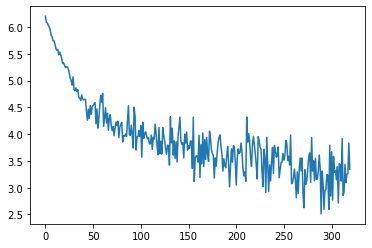

In [ ]:
plt.plot(loss_graph)
plt.show()

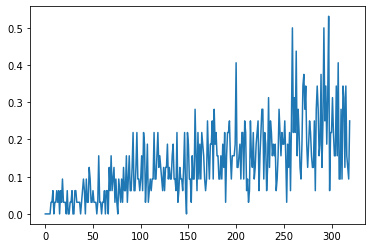

In [ ]:
plt.plot(accuracy_graph)
plt.show()

In [ ]:
epoch = 80  # 추가적인 학습

In [ ]:
for i in range(epoch):
  model.train()
  train_data = load_train
  for j,(src , tgt) in enumerate(tqdm(train_data)):

    optimizer.zero_grad()

    pred_start, pred_end = model(src[0].to(device),src[1].to(device),src[2].to(device))

    
    tgt = tgt[1].transpose(0,1)
    loss = (loss_fn(pred_start,tgt[0].to(device)) + loss_fn(pred_end,tgt[1].to(device)))/2

    loss.backward()

    optimizer.step()

    if j%100 == 0:
      match =(pred_start.argmax(1)==tgt[0].to(device)).sum()+(pred_end.argmax(1)==tgt[1].to(device)).sum()
      total = 2*tgt[0].size(0)
      print('\rloss: ',loss.item(),'   accuracy: ',match.item()/total,end="",flush=True)
      loss_graph.append(loss.item())
      accuracy_graph.append(match.item()/total)
  model.eval()
  dev_data = load_dev
  match =0
  total =0
  with torch.no_grad():
    for src , tgt in tqdm(dev_data):


      pred_start, pred_end = model(src[0].to(device),src[1].to(device),src[2].to(device))

      tgt = tgt[1].transpose(0,1)
      match += torch.sum(pred_start.argmax(1)==tgt[0].to(device))
      match += torch.sum(pred_end.argmax(1)==tgt[1].to(device)) #(pred_end.argmax(1)==tgt[1].to(device)).sum().item()
      total+=2*batch_size # 2* labels.size(0)

  print('accuracy: ',match/total)
  print('\nepoch:',i,flush=True)

  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  3.16015625    accuracy:  0.1875

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.2768, device='cuda:0')

epoch: 0


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.859264850616455    accuracy:  0.34375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.2806, device='cuda:0')

epoch: 1


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  3.53182315826416    accuracy:  0.125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.2863, device='cuda:0')

epoch: 2


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  3.0285611152648926    accuracy:  0.28125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.2934, device='cuda:0')

epoch: 3


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.973033905029297    accuracy:  0.28125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3044, device='cuda:0')

epoch: 4


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.982461929321289    accuracy:  0.375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3080, device='cuda:0')

epoch: 5


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  3.196415662765503    accuracy:  0.21875

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3113, device='cuda:0')

epoch: 6


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  3.4157609939575195    accuracy:  0.3125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3159, device='cuda:0')

epoch: 7


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  3.7487025260925293    accuracy:  0.15625

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3196, device='cuda:0')

epoch: 8


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.4612793922424316    accuracy:  0.375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3218, device='cuda:0')

epoch: 9


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.185637950897217    accuracy:  0.5

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3291, device='cuda:0')

epoch: 10


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.869859218597412    accuracy:  0.25

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3340, device='cuda:0')

epoch: 11


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  3.089297294616699    accuracy:  0.25

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3383, device='cuda:0')

epoch: 12


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.353874683380127    accuracy:  0.53125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3419, device='cuda:0')

epoch: 13


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.9206583499908447    accuracy:  0.21875

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3433, device='cuda:0')

epoch: 14


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.3584423065185547    accuracy:  0.46875

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3462, device='cuda:0')

epoch: 15


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.7757158279418945    accuracy:  0.375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3480, device='cuda:0')

epoch: 16


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.2840893268585205    accuracy:  0.53125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3498, device='cuda:0')

epoch: 17


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.33398175239563    accuracy:  0.34375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3511, device='cuda:0')

epoch: 18


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.744431257247925    accuracy:  0.28125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3527, device='cuda:0')

epoch: 19


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.579611301422119    accuracy:  0.3125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3551, device='cuda:0')

epoch: 20


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.2590556144714355    accuracy:  0.5625

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3561, device='cuda:0')

epoch: 21


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.760999917984009    accuracy:  0.3125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3612, device='cuda:0')

epoch: 22


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.220552444458008    accuracy:  0.46875

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3598, device='cuda:0')

epoch: 23


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.4046881198883057    accuracy:  0.3125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3626, device='cuda:0')

epoch: 24


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.782306671142578    accuracy:  0.3125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3653, device='cuda:0')

epoch: 25


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.626492500305176    accuracy:  0.34375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3695, device='cuda:0')

epoch: 26


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  1.9627842903137207    accuracy:  0.46875

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3679, device='cuda:0')

epoch: 27


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.1063437461853027    accuracy:  0.375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3736, device='cuda:0')

epoch: 28


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.406899929046631    accuracy:  0.3125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3758, device='cuda:0')

epoch: 29


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.5100326538085938    accuracy:  0.46875

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3764, device='cuda:0')

epoch: 30


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.958064079284668    accuracy:  0.28125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3772, device='cuda:0')

epoch: 31


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.525521755218506    accuracy:  0.4375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3791, device='cuda:0')

epoch: 32


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.262819766998291    accuracy:  0.40625

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3811, device='cuda:0')

epoch: 33


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.614199638366699    accuracy:  0.3125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3827, device='cuda:0')

epoch: 34


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.4587717056274414    accuracy:  0.40625

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3843, device='cuda:0')

epoch: 35


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.716470241546631    accuracy:  0.1875

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3862, device='cuda:0')

epoch: 36


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.4957053661346436    accuracy:  0.34375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3860, device='cuda:0')

epoch: 37


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.116274356842041    accuracy:  0.4375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3890, device='cuda:0')

epoch: 38


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.185382843017578    accuracy:  0.46875

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3910, device='cuda:0')

epoch: 39


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  1.896033763885498    accuracy:  0.5

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3927, device='cuda:0')

epoch: 40


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  1.9147381782531738    accuracy:  0.53125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3935, device='cuda:0')

epoch: 41


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  1.9794764518737793    accuracy:  0.5

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3953, device='cuda:0')

epoch: 42


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.4402034282684326    accuracy:  0.4375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3967, device='cuda:0')

epoch: 43


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.9732470512390137    accuracy:  0.25

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3967, device='cuda:0')

epoch: 44


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.9988508224487305    accuracy:  0.28125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.3985, device='cuda:0')

epoch: 45


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.310171127319336    accuracy:  0.40625

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4000, device='cuda:0')

epoch: 46


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.5822691917419434    accuracy:  0.28125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4004, device='cuda:0')

epoch: 47


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.1348962783813477    accuracy:  0.375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4030, device='cuda:0')

epoch: 48


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.149324417114258    accuracy:  0.375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4034, device='cuda:0')

epoch: 49


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.9141645431518555    accuracy:  0.375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4056, device='cuda:0')

epoch: 50


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.8018226623535156    accuracy:  0.3125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4050, device='cuda:0')

epoch: 51


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.0195438861846924    accuracy:  0.46875

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4079, device='cuda:0')

epoch: 52


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.075979232788086    accuracy:  0.46875

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4067, device='cuda:0')

epoch: 53


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.994174003601074    accuracy:  0.25

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4103, device='cuda:0')

epoch: 54


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.8219103813171387    accuracy:  0.3125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4111, device='cuda:0')

epoch: 55


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  1.924185037612915    accuracy:  0.5625

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4109, device='cuda:0')

epoch: 56


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.6290693283081055    accuracy:  0.375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4131, device='cuda:0')

epoch: 57


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.7555110454559326    accuracy:  0.34375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4162, device='cuda:0')

epoch: 58


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.210576057434082    accuracy:  0.40625

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4148, device='cuda:0')

epoch: 59


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.718921661376953    accuracy:  0.28125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4172, device='cuda:0')

epoch: 60


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  1.8463780879974365    accuracy:  0.4375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4166, device='cuda:0')

epoch: 61


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.100059747695923    accuracy:  0.40625

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4196, device='cuda:0')

epoch: 62


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.042548179626465    accuracy:  0.375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4194, device='cuda:0')

epoch: 63


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  1.8730050325393677    accuracy:  0.53125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4223, device='cuda:0')

epoch: 64


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.143632650375366    accuracy:  0.34375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4225, device='cuda:0')

epoch: 65


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.6854231357574463    accuracy:  0.46875

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4239, device='cuda:0')

epoch: 66


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.7251617908477783    accuracy:  0.28125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4233, device='cuda:0')

epoch: 67


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.059558629989624    accuracy:  0.4375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4229, device='cuda:0')

epoch: 68


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.337449312210083    accuracy:  0.40625

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4243, device='cuda:0')

epoch: 69


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.6633455753326416    accuracy:  0.21875

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4267, device='cuda:0')

epoch: 70


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.1226654052734375    accuracy:  0.375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4265, device='cuda:0')

epoch: 71


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.3834762573242188    accuracy:  0.5

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4269, device='cuda:0')

epoch: 72


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.708041191101074    accuracy:  0.34375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4286, device='cuda:0')

epoch: 73


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  1.7764134407043457    accuracy:  0.40625

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4282, device='cuda:0')

epoch: 74


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  1.6977869272232056    accuracy:  0.53125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4286, device='cuda:0')

epoch: 75


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.445016384124756    accuracy:  0.46875

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4282, device='cuda:0')

epoch: 76


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  1.7307416200637817    accuracy:  0.53125

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4304, device='cuda:0')

epoch: 77


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  2.00911808013916    accuracy:  0.46875

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4290, device='cuda:0')

epoch: 78


  0%|          | 0/1546 [00:00<?, ?it/s]

loss:  1.5551096200942993    accuracy:  0.59375

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4292, device='cuda:0')

epoch: 79


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/models/bert_new_a100.pth')

In [ ]:
model.eval()
dev_data = load_dev
match =0
total =0
with torch.no_grad():
  for src , tgt in tqdm(dev_data):


    pred_start, pred_end = model(src[0].to(device),src[1].to(device),src[2].to(device))

    tgt = tgt[1].transpose(0,1)
    match += torch.sum(pred_start.argmax(1)==tgt[0].to(device))
    match += torch.sum(pred_end.argmax(1)==tgt[1].to(device)) #(pred_end.argmax(1)==tgt[1].to(device)).sum().item()
    total+=2*batch_size # 2* labels.size(0)

  print('accuracy: ',match/total)

  0%|          | 0/154 [00:00<?, ?it/s]

accuracy:  tensor(0.4292, device='cuda:0')


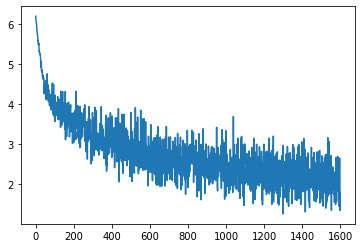

In [ ]:
plt.plot(loss_graph)
plt.show()

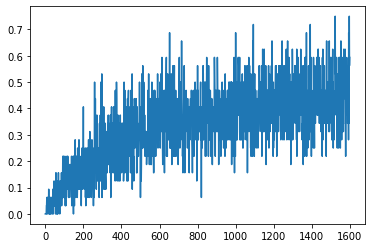

In [ ]:
plt.plot(accuracy_graph)
plt.show()

파인튜닝이라는 이름답게 LR 이 낮아야 학습이 진행되며 LR 이 높은 경우 bert 의 사전학습이 망가지며 파인튜닝이 진행되지않음(accuracy 의 상승이 없음)
파인튜닝의 경우 우상향을 보여주나 파인튜닝을 충분히 진행하지 않아 accuracy 가 
충분히 높지 않음.